<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_05_pytorch_sklearn_pipeline_03_class_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Baseline Code


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, precision_recall_curve, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
df = pd.read_excel(url, header=1)

# Rename columns to lower case and replace spaces with underscores
df.columns = [col.lower().replace(' ', '_') for col in df.columns]

# Select features and target
target = 'default_payment_next_month'
X = df.drop(columns=[target])
y = df[target]

# Perform stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify column types
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Define preprocessing for numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform the data
preprocessing_pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

optimal_threshold = 0.8000141978263855

# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the sklearn wrapper for the neural network model
class SklearnSimpleNN(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim, learning_rate=0.001, epochs=50, batch_size=64, pos_weight=1.0):
        self.input_dim = input_dim
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.pos_weight = pos_weight  # Accept as float
        self.model = SimpleNN(self.input_dim)

    def fit(self, X, y):
        # Convert pos_weight to tensor here
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.pos_weight, dtype=torch.float32))
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        train_dataset = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1))
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)

        for epoch in range(self.epochs):
            self.model.train()
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets.view(-1, 1))
                loss.backward()
                optimizer.step()
        return self

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(torch.tensor(X, dtype=torch.float32))
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > optimal_threshold).float()  # Use the manually adjusted threshold here
        return predictions.numpy().squeeze()

# Calculate the class weights
class_weights = len(y_train) / (2 * np.bincount(y_train))

# Create an instance of SklearnSimpleNN with the adjusted weight
input_dim = X_train_tensor.shape[1]
nn_estimator = SklearnSimpleNN(input_dim=input_dim, pos_weight=class_weights[1])

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
test_predictions = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print(classification_report(y_test_tensor.numpy(), test_predictions))


              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87      4673
         1.0       0.55      0.48      0.51      1327

    accuracy                           0.80      6000
   macro avg       0.70      0.68      0.69      6000
weighted avg       0.79      0.80      0.79      6000



### Exploring Resampling Techniques

Let's start by testing various resampling techniques from the `imblearn` library. Here are some techniques we'll explore:

1. **ADASYN (Adaptive Synthetic Sampling Approach)**:
   - Generates synthetic samples for the minority class, with more focus on difficult-to-learn examples.

2. **RandomUnderSampler**:
   - Randomly under-samples the majority class to balance the class distribution.

3. **BalancedBaggingClassifier**:
   - An ensemble method that performs balanced bootstrapping on the dataset.

#### Function to plot before and after target data imbalance

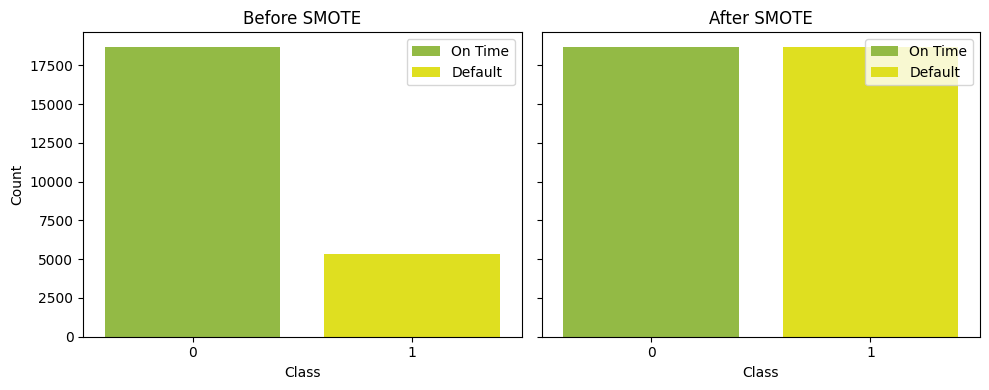

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_class_distribution(y_before, y_after, title_before="Before Resampling", title_after="After Resampling"):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    custom_colors = ['yellowgreen', 'yellow']

    # Plot before resampling
    sns.countplot(x=y_before, hue=y_before, palette=custom_colors, ax=axes[0], legend=False)
    axes[0].set_title(title_before)
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Count')
    axes[0].legend(['On Time', 'Default'])

    # Plot after resampling
    sns.countplot(x=y_after, hue=y_after, palette=custom_colors, ax=axes[1], legend=False)
    axes[1].set_title(title_after)
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Count')
    axes[1].legend(['On Time', 'Default'])

    plt.tight_layout()
    plt.show()

# Example usage before and after SMOTE
y_before = y_train
y_after = y_train_resampled

plot_class_distribution(y_before, y_after, title_before='Before SMOTE', title_after='After SMOTE')


### ADASYN

### Summary of ADASYN (Adaptive Synthetic Sampling Approach)

**What is ADASYN?**

ADASYN, short for Adaptive Synthetic Sampling Approach for Imbalanced Learning, is a technique designed to handle imbalanced datasets. It generates synthetic data points for the minority class to balance the class distribution. The goal is to reduce the bias introduced by class imbalance and improve the performance of machine learning models.

**How Does ADASYN Work?**

1. **Identifying Minority Class Examples**:
   - ADASYN first identifies the minority class examples in the dataset.

2. **Calculating Class Imbalance Degree**:
   - It calculates the degree of imbalance between the majority and minority classes.

3. **Determining Synthetic Sample Generation**:
   - ADASYN determines the number of synthetic samples to generate for each minority class example based on its difficulty of learning, which is estimated by the density of majority class examples around it.
   - Minority examples surrounded by more majority class examples are considered harder to learn and will have more synthetic samples generated.

4. **Generating Synthetic Samples**:
   - For each minority class example, synthetic samples are generated by interpolating between the example and its k-nearest minority class neighbors.
   - The interpolation is weighted by the density of majority class examples around each minority example, focusing more on harder-to-learn examples.

5. **Balancing the Dataset**:
   - The synthetic samples are added to the dataset, resulting in a more balanced class distribution.

**Advantages of ADASYN**:
- Focuses on generating synthetic samples for harder-to-learn examples, potentially leading to better model performance on difficult cases.
- Adaptively adjusts the number of synthetic samples based on local data distribution, which can provide a more nuanced approach to balancing.

**Limitations of ADASYN**:
- Like other synthetic sampling methods, it can introduce noise if not used carefully.
- May lead to overfitting if the synthetic samples do not accurately represent real-world data variations.

**When to Use ADASYN**:
- ADASYN is particularly useful when the dataset has a significant class imbalance and the minority class has complex decision boundaries that are hard for models to learn.



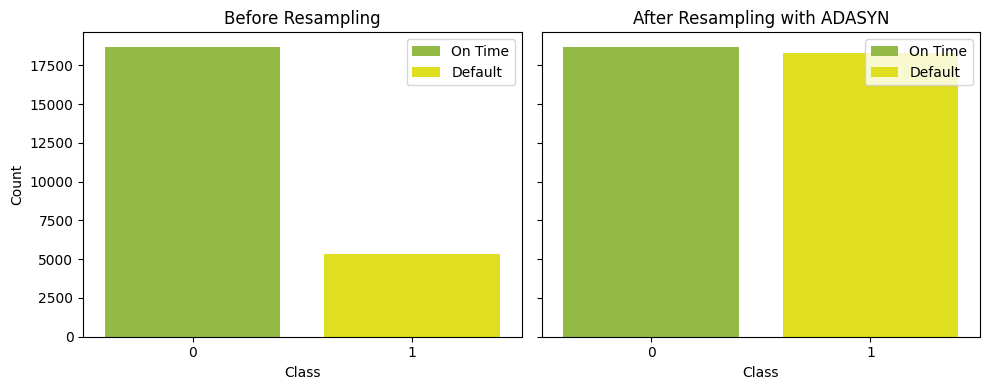

ADASYN Resampling:
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      4673
         1.0       0.48      0.53      0.50      1327

    accuracy                           0.77      6000
   macro avg       0.67      0.68      0.67      6000
weighted avg       0.78      0.77      0.77      6000



In [9]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN to balance the training dataset
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train_processed, y_train)

# Plot after resampling with ADASYN
plot_class_distribution(y_train, y_train_resampled, title_before="Before Resampling", title_after="After Resampling with ADASYN")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
test_predictions = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print("ADASYN Resampling:")
print(classification_report(y_test_tensor.numpy(), test_predictions))

## RandomUnderSampler

### What is RandomUnderSampler?

RandomUnderSampler is a technique used to handle class imbalance in datasets by reducing the number of samples from the majority class. It randomly removes instances from the majority class until the class distribution is balanced or reaches a specified ratio.

**How Does RandomUnderSampler Work?**

1. **Identifying Majority and Minority Classes**:
   - The method identifies the majority and minority classes in the dataset.

2. **Determining the Sampling Strategy**:
   - A target ratio of minority to majority class samples is set. This can be done automatically to balance the classes or specified by the user.

3. **Random Sampling**:
   - RandomUnderSampler randomly selects and removes instances from the majority class until the desired class ratio is achieved.

4. **Balancing the Dataset**:
   - The resulting dataset has a more balanced class distribution with fewer instances from the majority class.

**Advantages of RandomUnderSampler**:
- Simple and easy to implement.
- Can effectively balance the class distribution by reducing the size of the majority class.

**Limitations of RandomUnderSampler**:
- Potentially removes informative instances from the majority class, which can lead to loss of information.
- Might not be suitable for small datasets, as it reduces the number of training samples.


### Undersampling (SMOTE)

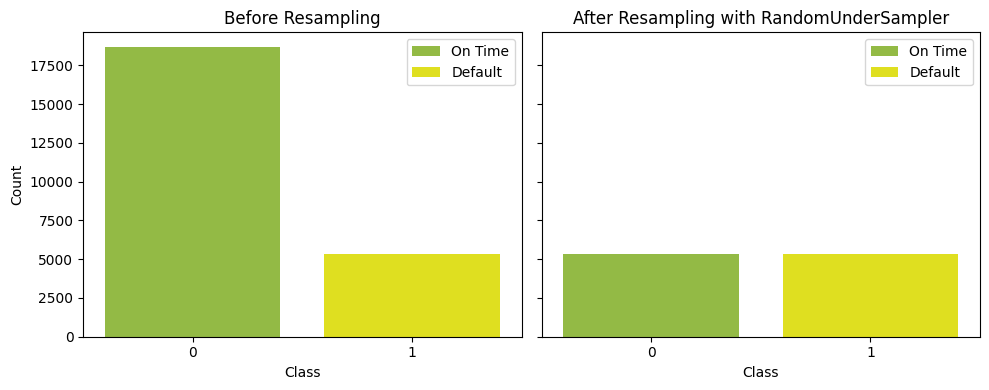

RandomUnderSampler Resampling:
              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86      4673
         1.0       0.52      0.51      0.51      1327

    accuracy                           0.79      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.78      0.79      0.79      6000



In [14]:
from imblearn.under_sampling import RandomUnderSampler

# Apply RandomUnderSampler to balance the training dataset
undersampler = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train_processed, y_train)

# Plot after resampling with RandomUnderSampler
plot_class_distribution(y_train, y_train_resampled, title_before="Before Resampling", title_after="After Resampling with RandomUnderSampler")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
test_predictions_optimal_threshold = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print("RandomUnderSampler Resampling:")
print(classification_report(y_test_tensor.numpy(), test_predictions_optimal_threshold))

### Oversampling (SMOTE)

### Summary of Oversampling

**What is Oversampling?**

Oversampling is a technique used to handle class imbalance by increasing the number of instances in the minority class. This can be done through duplication of existing samples or generating synthetic samples (like SMOTE or ADASYN).

**How Does Oversampling Work?**

1. **Identifying Minority Class**:
   - The method identifies the minority class in the dataset.

2. **Generating Additional Samples**:
   - Oversampling generates additional samples for the minority class to balance the class distribution. This can be done through simple duplication or synthetic sample generation (e.g., SMOTE, ADASYN).

3. **Balancing the Dataset**:
   - The resulting dataset has more balanced class distribution with additional instances in the minority class.

**Advantages of Oversampling**:
- Increases the representation of the minority class without reducing the number of majority class samples.
- Can improve model performance on imbalanced datasets by providing more training examples for the minority class.

**Limitations of Oversampling**:
- Can lead to overfitting, especially if simple duplication is used, as the model might memorize the duplicated samples.
- Increases the size of the dataset, which can lead to longer training times and higher computational costs.






In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Plot after resampling with SMOTE
plot_class_distribution(y_train, y_train_resampled, title_before="Before Resampling", title_after="After Resampling with SMOTE")

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)

# Fit the model
nn_estimator.fit(X_train_tensor.numpy(), y_train_tensor.numpy())

# Predict on the test set with the optimal threshold
test_predictions_optimal_threshold = nn_estimator.predict(X_test_tensor.numpy())

# Evaluate the model with the optimal threshold
print("SMOTE Resampling:")
print(classification_report(y_test_tensor.numpy(), test_predictions_optimal_threshold))

### Choosing Between Oversampling and Undersampling

**When to Use Oversampling**:
- When the dataset is small and removing majority class samples would lead to loss of valuable information.
- When you want to improve model performance on the minority class by providing more training examples.
- When you have the computational resources to handle the increased dataset size.

**When to Use Undersampling**:
- When the dataset is large, and you can afford to remove some majority class samples without losing significant information.
- When you want to reduce the size of the dataset to decrease training times and computational costs.
- When you want to quickly balance the class distribution without increasing the dataset size.

## BalancedBaggingClassifier

In [12]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=42)

# Fit the model
bbc.fit(X_train_processed, y_train)

# Predict on the test set
test_predictions = bbc.predict(X_test_processed)

# Evaluate the model
print("BalancedBaggingClassifier Resampling:")
print(classification_report(y_test_tensor.numpy(), test_predictions))

BalancedBaggingClassifier Resampling:
              precision    recall  f1-score   support

         0.0       0.86      0.84      0.85      4673
         1.0       0.48      0.52      0.50      1327

    accuracy                           0.77      6000
   macro avg       0.67      0.68      0.67      6000
weighted avg       0.78      0.77      0.77      6000

